In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
img1 = cv2.imread('couple.jpg', 0)

In [3]:
img2 = cv2.imread('a.jpg', 0)

In [4]:
def plot_res(img, img_eq):

    # plotting for orignal image        
    hist, bins = np.histogram(img.ravel(), 256, [0, 256])
    pdf = hist / np.prod(img.shape)
    plt.figure(figsize=(12,10))
    plt.subplot(2, 2, 1)
    plt.plot(pdf, color='r')
    plt.title("Before")
    plt.xlim([0, 256])
    plt.ylim([0, pdf.max()+0.005])
    plt.subplot(2, 2, 2)
    plt.imshow(img, cmap="gray")
    
    # plotting for equalizated image
    hist2, bin2 = np.histogram(img_eq, 256)
    pdf2 = hist2 / np.prod(img.shape)
    plt.subplot(2, 2, 3)
    plt.plot(pdf2, color='r')
    plt.title("After")
    plt.xlim([0, 256])
    plt.ylim([0, pdf2.max()+0.005])    
    plt.subplot(2, 2, 4)   
    plt.imshow(img_eq, cmap="gray")

### Basic Histogram Equalization

In [5]:
def basic_eq(img):
    
    hist, bins = np.histogram(img.ravel(), 256, [0, 256])
    pdf = hist / np.prod(img.shape)
    cdf = hist.cumsum()
    
    # getting the new cdf
    cdf = cdf *(cdf[-1] - cdf[0]) + cdf[0]

    # get new img 
    img_shape = img.shape
    img_eq = np.zeros((img_shape), dtype=np.uint8)
    img_eq = cdf[img]

    return img_eq

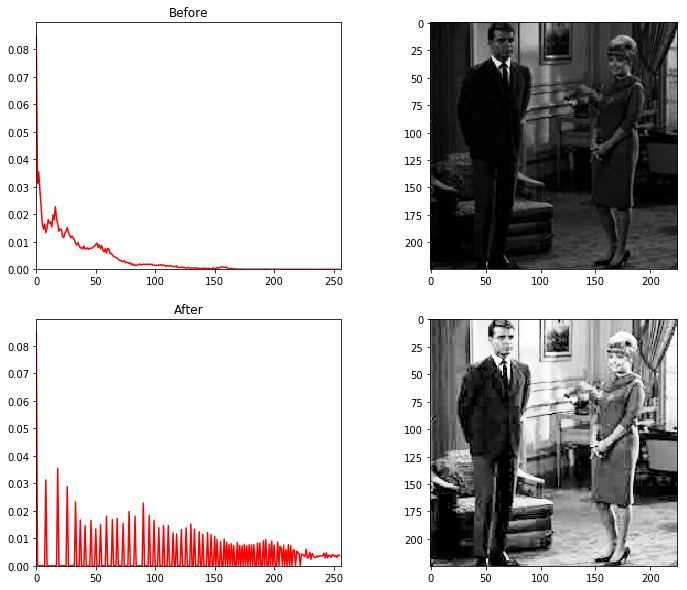

In [6]:
img1_eq = basic_eq(img1)
plot_res(img1, img1_eq)

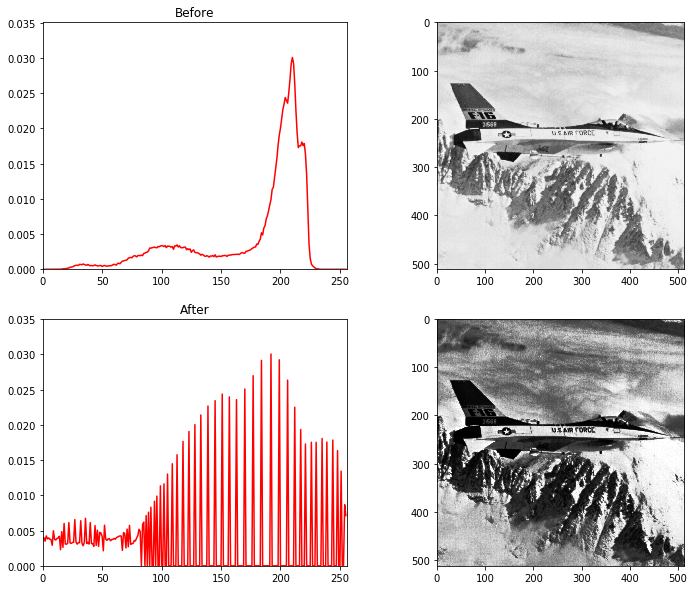

In [7]:
img2_eq = basic_eq(img2)
plot_res(img2, img2_eq)

### Basic HE 的缺点

+ 在低灰度值范围内密度很大（img1）的图片中，亮度会有过度的变化，使得原来很暗的图像变得异常亮，这样很不自然。
+ 在高灰度值范围内密度很大（img2）的图片中，可以看到在均衡之后，我们会在云周围看到完全不同的视觉识别。也可以观察到飞机上的字母和标志周围的对比度降低了。

直方图均衡的这种限制背后的更根本原因是，直方图均衡不考虑图像的平均亮度。
> More fundamental reason behind the such limi- tations of the histogram equalzat,ion is that the his- toram equalzation does not take the mean brightness of an image into account.

### BI-Histogram Equalization

用 $X_{m}$ 表示图像 X 的平均值，并假设 $X_{m} ∈\left \{ X_{0}, X_{1}, ..., X_{L-1} \right \}$ ，基于均值可以将图像分为两部分 $X_{L}$ 和 $X_{U}$，整个可以表示成：$$X = X_{L}\cup X_{U}$$

其中 $$

In [8]:
def bi_eq(img):
    
    hist, bins = np.histogram(img.ravel(), 256, [0, 256])
    pdf = hist / np.prod(img.shape)
    cdf = hist.cumsum()

    
    # image mean
    img_mean = np.mean(img)
    
    # getting two subimages
    img_l = np.zeros((img.shape))
    img_u = np.zeros((img.shape))
    
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            if img[i][j] <= img_mean:
                img_l[i][j] = img[i][j]
            else:
                img_u[i][j] = img[i][j]
                
    # cdf of low subimage
    hist_l, bins_l = np.histogram(img_l, 256, [0, 256])
    cdf_l = hist_l.cumsum()

    # transform func of low
    cdf_l = cdf_l *(img_mean - img.min()) + img.min()          
    
    
    # cdf of upper subimage
    hist_u, bins_u = np.histogram(img_u, 256, [0, 256])
    cdf_u = hist_u.cumsum()

    # transform func of upper
    cdf_u = cdf_u *(img.max() - (int(img_mean) + 1)) + (int(img_mean) + 1)
    
    cdf_new = cdf_l + cdf_u
    new_img = cdf_new[img.ravel()]
    img_eq = np.reshape(new_img, img.shape)
    
    return img_eq

### Compare

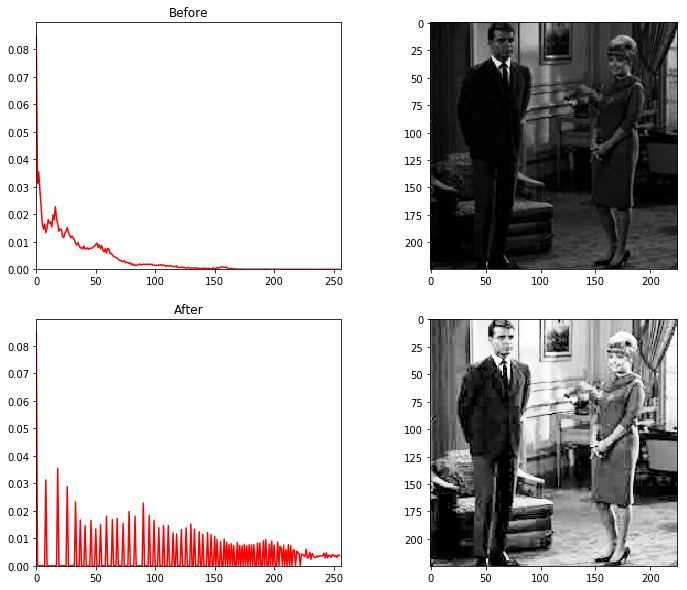

In [9]:
img1_eq = basic_eq(img1)
plot_res(img1, img1_eq)

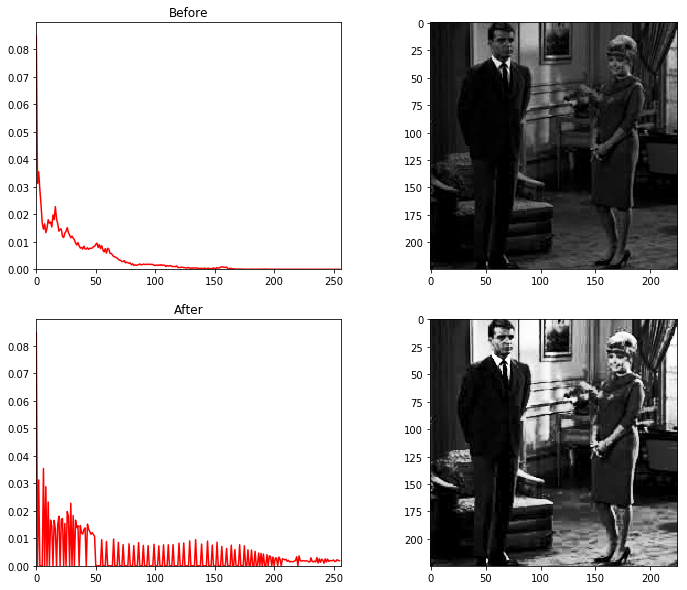

In [10]:
img1_bieq = bi_eq(img1)
plot_res(img1, img1_bieq)

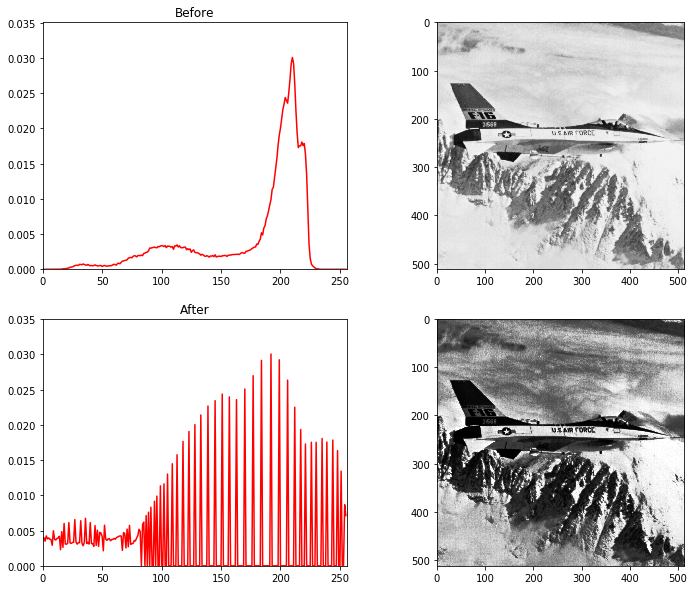

In [11]:
img2_eq = basic_eq(img2)
plot_res(img2, img2_eq)

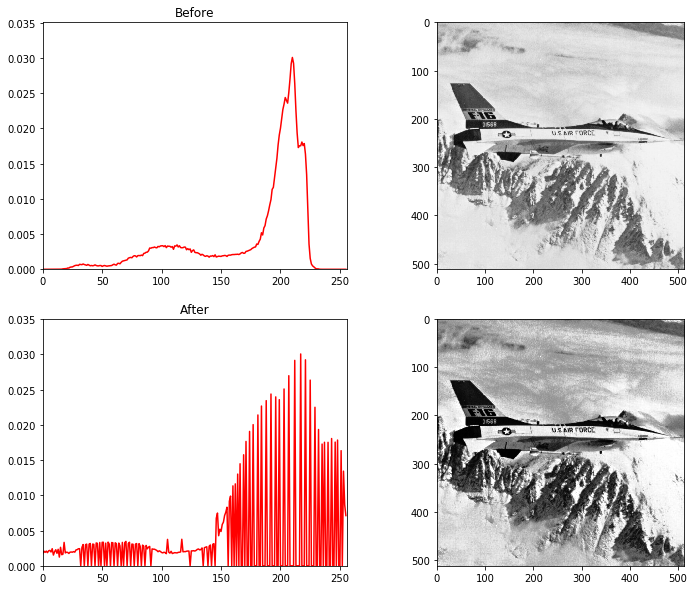

In [12]:
img2_bieq = bi_eq(img2)
plot_res(img2, img2_bieq)